In [236]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
import re
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold


In [237]:
#Loading the dataset from the file
df =pd.read_csv('/content/tour_logs_train.csv')
df.head(10)

,Gig_ID,Venue_ID,Show_DateTime,Day_of_Week,Volume_Level,Ticket_Price,Crowd_Size,Opener_Rating,Weather,Moon_Phase,Band_Outfit,Merch_Sales_Post_Show,Crowd_Energy
0,Gig_0000,V_Alpha,2024-03-07 21:00:00,3,5.0,52.93,464.0,2,Rainy,Waning Crescent,Leather,916,64.96
1,Gig_0001,V_Beta,2024-09-05 22:00:00,3,2.0,66.33,388.0,5,Clear,New Moon,Leather,1003,66.42
2,Gig_0002,V_Delta,2024-03-09 15:00:00,5,1.0,51.37,679.0,1,Rainy,Waning Crescent,Denim,720,42.58
3,Gig_0003,V_Beta,08/07/2024 08:00 AM,0,10.0,64.77,454.0,1,Rainy,New Moon,Leather,0,0.00
4,Gig_0004,V_Delta,2024-04-26 17:00:00,4,8.0,47.34,654.0,5,Cloudy,Full Moon,Spandex,950,67.55
5,Gig_0005,V_Alpha,2024-09-11 20:00:00,2,3.0,69.63,320.0,4,Cloudy,First Quarter,Denim,914,67.87
6,Gig_0006,V_Gamma,2024-04-09 19:00:00,1,4.0,£54.69,107.0,3,Clear,New Moon,Leather,1372,85.45
7,Gig_0007,V_Alpha,2024-06-06 20:00:00,3,2.0,77.17,637.0,3,Cloudy,Waning Crescent,Spandex,1018,66.75
8,Gig_0008,V_Gamma,2024-03-12 17:00:00,1,8.0,€44.08,539.0,5,Clear,New Moon,Leather,583,40.85
9,Gig_0009,V_Delta,2024-03-21 19:00:00,3,9.0,43.09,488.0,3,Cloudy,First Quarter,Spandex,551,43.92


In [238]:
#Performing Data Cleaning as Some Data are Not Possible as per scribble txt that capacity is less than 1000 and Crowd Energy cannot be negative and Greater than 100
df['Crowd_Energy'] = df['Crowd_Energy'].apply(lambda x: np.nan if x > 100 or x < 0 else x)
df['Crowd_Size'] = df['Crowd_Size'].apply(lambda x: np.nan if x > 1000 or x < 0 else x)

In [239]:
#as it is data leakage bcoz it is data post show (as will not be available pre show)
#as gig_ID is just a index maintaining record , therefore it is red herrings. So I remove it.
df=df.drop(columns='Merch_Sales_Post_Show')
df=df.drop(columns='Gig_ID')
df.head(10)

,Venue_ID,Show_DateTime,Day_of_Week,Volume_Level,Ticket_Price,Crowd_Size,Opener_Rating,Weather,Moon_Phase,Band_Outfit,Crowd_Energy
0,V_Alpha,2024-03-07 21:00:00,3,5.0,52.93,464.0,2,Rainy,Waning Crescent,Leather,64.96
1,V_Beta,2024-09-05 22:00:00,3,2.0,66.33,388.0,5,Clear,New Moon,Leather,66.42
2,V_Delta,2024-03-09 15:00:00,5,1.0,51.37,679.0,1,Rainy,Waning Crescent,Denim,42.58
3,V_Beta,08/07/2024 08:00 AM,0,10.0,64.77,454.0,1,Rainy,New Moon,Leather,0.00
4,V_Delta,2024-04-26 17:00:00,4,8.0,47.34,654.0,5,Cloudy,Full Moon,Spandex,67.55
5,V_Alpha,2024-09-11 20:00:00,2,3.0,69.63,320.0,4,Cloudy,First Quarter,Denim,67.87
6,V_Gamma,2024-04-09 19:00:00,1,4.0,£54.69,107.0,3,Clear,New Moon,Leather,85.45
7,V_Alpha,2024-06-06 20:00:00,3,2.0,77.17,637.0,3,Cloudy,Waning Crescent,Spandex,66.75
8,V_Gamma,2024-03-12 17:00:00,1,8.0,€44.08,539.0,5,Clear,New Moon,Leather,40.85
9,V_Delta,2024-03-21 19:00:00,3,9.0,43.09,488.0,3,Cloudy,First Quarter,Spandex,43.92


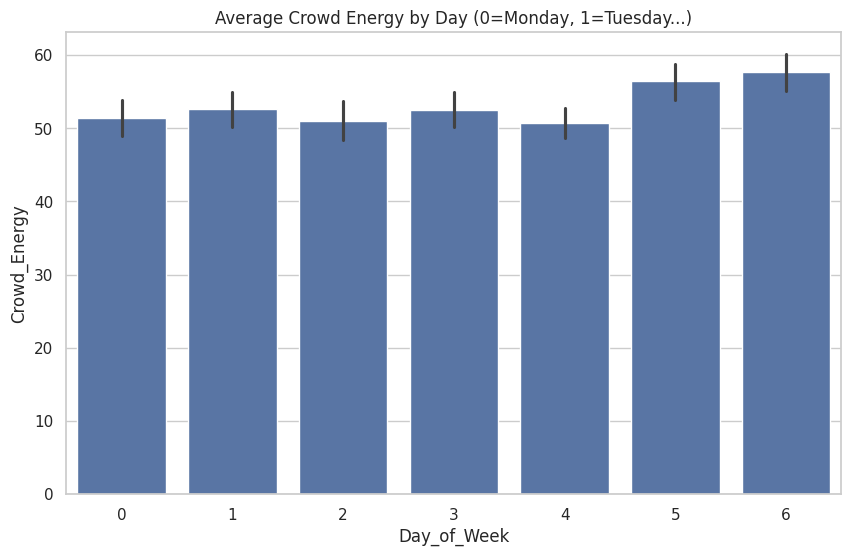

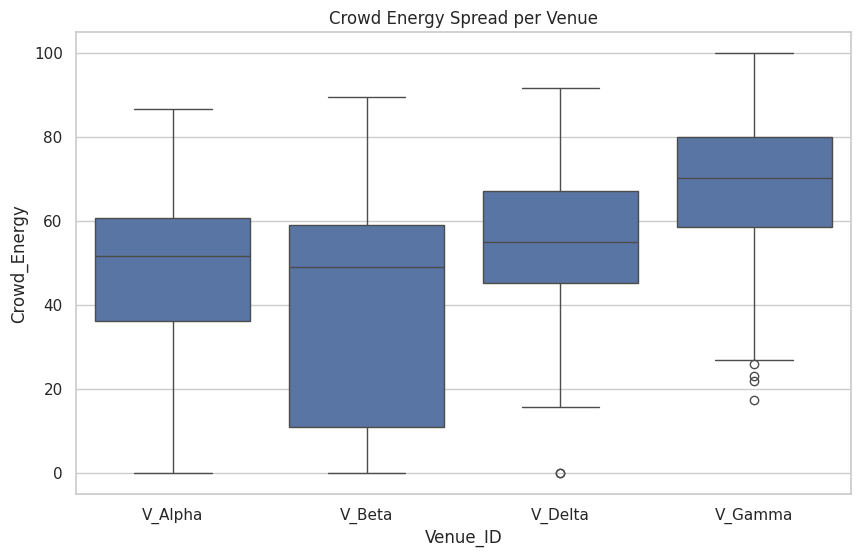

In [240]:
#Exploratory Data Analysis
import seaborn as sns
import matplotlib.pyplot as plt

# Testing the Tuesday Curse
plt.figure(figsize=(10,6))
sns.barplot(x='Day_of_Week', y='Crowd_Energy', data=df)
plt.title('Average Crowd Energy by Day (0=Monday, 1=Tuesday...)')
plt.show()

# Venue- Energy Distribution
plt.figure(figsize=(10,6))
sns.boxplot(x='Venue_ID', y='Crowd_Energy', data=df)
plt.title('Crowd Energy Spread per Venue')
plt.show()



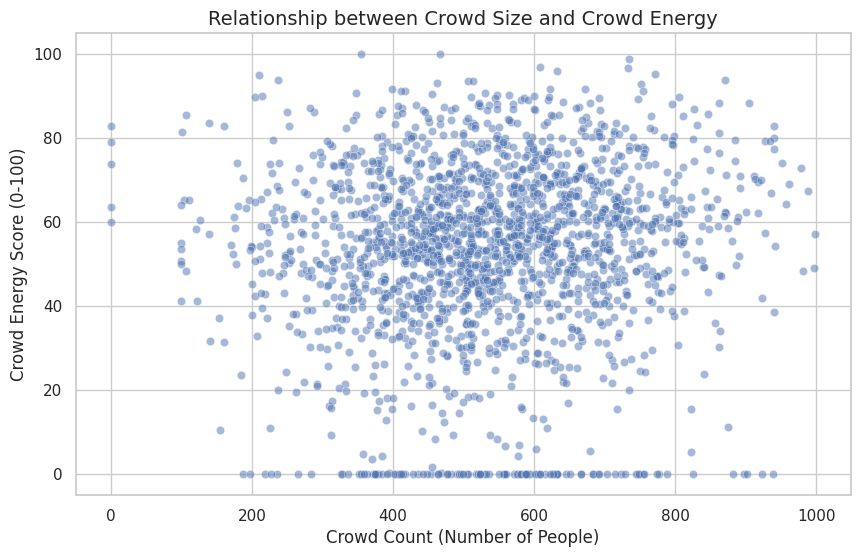

In [241]:
#EDA for Crowd Size VS Crowd Energy
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Crowd_Size', y='Crowd_Energy', alpha=0.5)
plt.title('Relationship between Crowd Size and Crowd Energy', fontsize=14)
plt.xlabel('Crowd Count (Number of People)', fontsize=12)
plt.ylabel('Crowd Energy Score (0-100)', fontsize=12)

plt.show()

<Axes: xlabel='Volume_Level', ylabel='Crowd_Energy'>

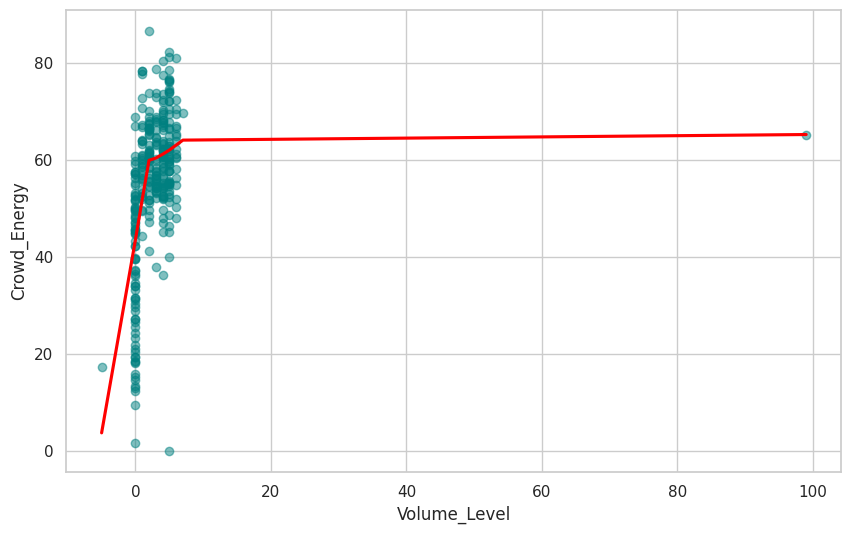

In [242]:
#EDA for Crowd Energy vs Volume Level at V_Alpha
v_alpha_data = df[df['Venue_ID'] == 'V_Alpha']
plt.figure(figsize=(10, 6))
sns.regplot(data=v_alpha_data, x='Volume_Level', y='Crowd_Energy',
    scatter_kws={'alpha':0.5, 'color':'teal'},
    line_kws={'color':'red'},
    lowess=True
)

In [243]:
#Coding Different Venue To Categorize Them as Number to fit Machine
venue_code = {'V_Alpha':1,'V_Beta':2,'V_Gamma':3,'V_Delta':4}
df['Venue_ID'] = df['Venue_ID'].map(venue_code)
df.head()

,Venue_ID,Show_DateTime,Day_of_Week,Volume_Level,Ticket_Price,Crowd_Size,Opener_Rating,Weather,Moon_Phase,Band_Outfit,Crowd_Energy
0,1,2024-03-07 21:00:00,3,5.0,52.93,464.0,2,Rainy,Waning Crescent,Leather,64.96
1,2,2024-09-05 22:00:00,3,2.0,66.33,388.0,5,Clear,New Moon,Leather,66.42
2,4,2024-03-09 15:00:00,5,1.0,51.37,679.0,1,Rainy,Waning Crescent,Denim,42.58
3,2,08/07/2024 08:00 AM,0,10.0,64.77,454.0,1,Rainy,New Moon,Leather,0.00
4,4,2024-04-26 17:00:00,4,8.0,47.34,654.0,5,Cloudy,Full Moon,Spandex,67.55


In [244]:
#Coding Different Venue To Categorize Them as Number to fit Machine Learning Pipeline
Weather_Code = {'Rainy':1,'Clear':2,'Cloudy':3,'Stormy':4}
df['Weather'] = df['Weather'].map(Weather_Code)
df.head(10)

,Venue_ID,Show_DateTime,Day_of_Week,Volume_Level,Ticket_Price,Crowd_Size,Opener_Rating,Weather,Moon_Phase,Band_Outfit,Crowd_Energy
0,1,2024-03-07 21:00:00,3,5.0,52.93,464.0,2,1,Waning Crescent,Leather,64.96
1,2,2024-09-05 22:00:00,3,2.0,66.33,388.0,5,2,New Moon,Leather,66.42
2,4,2024-03-09 15:00:00,5,1.0,51.37,679.0,1,1,Waning Crescent,Denim,42.58
3,2,08/07/2024 08:00 AM,0,10.0,64.77,454.0,1,1,New Moon,Leather,0.00
4,4,2024-04-26 17:00:00,4,8.0,47.34,654.0,5,3,Full Moon,Spandex,67.55
5,1,2024-09-11 20:00:00,2,3.0,69.63,320.0,4,3,First Quarter,Denim,67.87
6,3,2024-04-09 19:00:00,1,4.0,£54.69,107.0,3,2,New Moon,Leather,85.45
7,1,2024-06-06 20:00:00,3,2.0,77.17,637.0,3,3,Waning Crescent,Spandex,66.75
8,3,2024-03-12 17:00:00,1,8.0,€44.08,539.0,5,2,New Moon,Leather,40.85
9,4,2024-03-21 19:00:00,3,9.0,43.09,488.0,3,3,First Quarter,Spandex,43.92


In [245]:
#Categorizing the Moon phase as Number to fit ml pipeline
Moon_Code={'Waning Crescent':1, 'New Moon':2, 'Full Moon':3, 'First Quarter':4, 'Last Quarter':5,
       'Waning Gibbous':6, 'Waxing Crescent':7, 'Waxing Gibbous':8}
df['Moon_Phase'] = df['Moon_Phase'].map(Moon_Code)
df.head(10)

,Venue_ID,Show_DateTime,Day_of_Week,Volume_Level,Ticket_Price,Crowd_Size,Opener_Rating,Weather,Moon_Phase,Band_Outfit,Crowd_Energy
0,1,2024-03-07 21:00:00,3,5.0,52.93,464.0,2,1,1,Leather,64.96
1,2,2024-09-05 22:00:00,3,2.0,66.33,388.0,5,2,2,Leather,66.42
2,4,2024-03-09 15:00:00,5,1.0,51.37,679.0,1,1,1,Denim,42.58
3,2,08/07/2024 08:00 AM,0,10.0,64.77,454.0,1,1,2,Leather,0.00
4,4,2024-04-26 17:00:00,4,8.0,47.34,654.0,5,3,3,Spandex,67.55
5,1,2024-09-11 20:00:00,2,3.0,69.63,320.0,4,3,4,Denim,67.87
6,3,2024-04-09 19:00:00,1,4.0,£54.69,107.0,3,2,2,Leather,85.45
7,1,2024-06-06 20:00:00,3,2.0,77.17,637.0,3,3,1,Spandex,66.75
8,3,2024-03-12 17:00:00,1,8.0,€44.08,539.0,5,2,2,Leather,40.85
9,4,2024-03-21 19:00:00,3,9.0,43.09,488.0,3,3,4,Spandex,43.92


In [246]:
#Categorizing the Band Outfit as different number code
Outfit_Code={'Leather':1, 'Denim':2, 'Spandex':3}
df['Band_Outfit'] = df['Band_Outfit'].map(Outfit_Code)
df.head(10)

,Venue_ID,Show_DateTime,Day_of_Week,Volume_Level,Ticket_Price,Crowd_Size,Opener_Rating,Weather,Moon_Phase,Band_Outfit,Crowd_Energy
0,1,2024-03-07 21:00:00,3,5.0,52.93,464.0,2,1,1,1,64.96
1,2,2024-09-05 22:00:00,3,2.0,66.33,388.0,5,2,2,1,66.42
2,4,2024-03-09 15:00:00,5,1.0,51.37,679.0,1,1,1,2,42.58
3,2,08/07/2024 08:00 AM,0,10.0,64.77,454.0,1,1,2,1,0.00
4,4,2024-04-26 17:00:00,4,8.0,47.34,654.0,5,3,3,3,67.55
5,1,2024-09-11 20:00:00,2,3.0,69.63,320.0,4,3,4,2,67.87
6,3,2024-04-09 19:00:00,1,4.0,£54.69,107.0,3,2,2,1,85.45
7,1,2024-06-06 20:00:00,3,2.0,77.17,637.0,3,3,1,3,66.75
8,3,2024-03-12 17:00:00,1,8.0,€44.08,539.0,5,2,2,1,40.85
9,4,2024-03-21 19:00:00,3,9.0,43.09,488.0,3,3,4,3,43.92


In [247]:
#Formatting The Date And Time in a Standard Format
df['Show_Datetime']=pd.to_datetime(df['Show_DateTime'], format ='mixed', dayfirst=True,errors='coerce')
df.head(10)

,Venue_ID,Show_DateTime,Day_of_Week,Volume_Level,Ticket_Price,Crowd_Size,Opener_Rating,Weather,Moon_Phase,Band_Outfit,Crowd_Energy,Show_Datetime
0,1,2024-03-07 21:00:00,3,5.0,52.93,464.0,2,1,1,1,64.96,2024-03-07 21:00:00
1,2,2024-09-05 22:00:00,3,2.0,66.33,388.0,5,2,2,1,66.42,2024-09-05 22:00:00
2,4,2024-03-09 15:00:00,5,1.0,51.37,679.0,1,1,1,2,42.58,2024-03-09 15:00:00
3,2,08/07/2024 08:00 AM,0,10.0,64.77,454.0,1,1,2,1,0.00,2024-07-08 08:00:00
4,4,2024-04-26 17:00:00,4,8.0,47.34,654.0,5,3,3,3,67.55,2024-04-26 17:00:00
5,1,2024-09-11 20:00:00,2,3.0,69.63,320.0,4,3,4,2,67.87,2024-09-11 20:00:00
6,3,2024-04-09 19:00:00,1,4.0,£54.69,107.0,3,2,2,1,85.45,2024-04-09 19:00:00
7,1,2024-06-06 20:00:00,3,2.0,77.17,637.0,3,3,1,3,66.75,2024-06-06 20:00:00
8,3,2024-03-12 17:00:00,1,8.0,€44.08,539.0,5,2,2,1,40.85,2024-03-12 17:00:00
9,4,2024-03-21 19:00:00,3,9.0,43.09,488.0,3,3,4,3,43.92,2024-03-21 19:00:00


In [248]:
#Feature Engineering
#Extracting only time from the Show Date and Time as Date Should Not affect but Timing matters as cited many times in document.
df['show_time'] = df['Show_Datetime'].dt.time
df.head(10)

,Venue_ID,Show_DateTime,Day_of_Week,Volume_Level,Ticket_Price,Crowd_Size,Opener_Rating,Weather,Moon_Phase,Band_Outfit,Crowd_Energy,Show_Datetime,show_time
0,1,2024-03-07 21:00:00,3,5.0,52.93,464.0,2,1,1,1,64.96,2024-03-07 21:00:00,21:00:00
1,2,2024-09-05 22:00:00,3,2.0,66.33,388.0,5,2,2,1,66.42,2024-09-05 22:00:00,22:00:00
2,4,2024-03-09 15:00:00,5,1.0,51.37,679.0,1,1,1,2,42.58,2024-03-09 15:00:00,15:00:00
3,2,08/07/2024 08:00 AM,0,10.0,64.77,454.0,1,1,2,1,0.00,2024-07-08 08:00:00,08:00:00
4,4,2024-04-26 17:00:00,4,8.0,47.34,654.0,5,3,3,3,67.55,2024-04-26 17:00:00,17:00:00
5,1,2024-09-11 20:00:00,2,3.0,69.63,320.0,4,3,4,2,67.87,2024-09-11 20:00:00,20:00:00
6,3,2024-04-09 19:00:00,1,4.0,£54.69,107.0,3,2,2,1,85.45,2024-04-09 19:00:00,19:00:00
7,1,2024-06-06 20:00:00,3,2.0,77.17,637.0,3,3,1,3,66.75,2024-06-06 20:00:00,20:00:00
8,3,2024-03-12 17:00:00,1,8.0,€44.08,539.0,5,2,2,1,40.85,2024-03-12 17:00:00,17:00:00
9,4,2024-03-21 19:00:00,3,9.0,43.09,488.0,3,3,4,3,43.92,2024-03-21 19:00:00,19:00:00


In [249]:
#Dropping Both Date and Time Of previous Columns That are not in use
df=df.drop(columns='Show_DateTime')
df=df.drop(columns='Show_Datetime')
df.head(10)

,Venue_ID,Day_of_Week,Volume_Level,Ticket_Price,Crowd_Size,Opener_Rating,Weather,Moon_Phase,Band_Outfit,Crowd_Energy,show_time
0,1,3,5.0,52.93,464.0,2,1,1,1,64.96,21:00:00
1,2,3,2.0,66.33,388.0,5,2,2,1,66.42,22:00:00
2,4,5,1.0,51.37,679.0,1,1,1,2,42.58,15:00:00
3,2,0,10.0,64.77,454.0,1,1,2,1,0.00,08:00:00
4,4,4,8.0,47.34,654.0,5,3,3,3,67.55,17:00:00
5,1,2,3.0,69.63,320.0,4,3,4,2,67.87,20:00:00
6,3,1,4.0,£54.69,107.0,3,2,2,1,85.45,19:00:00
7,1,3,2.0,77.17,637.0,3,3,1,3,66.75,20:00:00
8,3,1,8.0,€44.08,539.0,5,2,2,1,40.85,17:00:00
9,4,3,9.0,43.09,488.0,3,3,4,3,43.92,19:00:00


In [250]:
#Maintaining Currency in Usd Only by converting them as per their rates
rates = {'£': 1.27,'€': 1.09,'$':1.00}
def convert_to_usd(price):
    if pd.isna(price):
        return 0.0

    price_str = str(price)
    numeric_part = re.search(r"(\d+\.?\d*)", price_str)
    if not numeric_part:
        return 0.0
    amt = float(numeric_part.group(1))
    if '£' in price_str:
        return amt * rates['£']
    elif '€' in price_str:
        return amt * rates['€']
    else:
        return amt *rates['$']
df['Ticket_Price_USD'] = df['Ticket_Price'].apply(convert_to_usd)
df.head(15)


,Venue_ID,Day_of_Week,Volume_Level,Ticket_Price,Crowd_Size,Opener_Rating,Weather,Moon_Phase,Band_Outfit,Crowd_Energy,show_time,Ticket_Price_USD
0,1,3,5.0,52.93,464.0,2,1,1,1,64.96,21:00:00,52.9300
1,2,3,2.0,66.33,388.0,5,2,2,1,66.42,22:00:00,66.3300
2,4,5,1.0,51.37,679.0,1,1,1,2,42.58,15:00:00,51.3700
3,2,0,10.0,64.77,454.0,1,1,2,1,0.00,08:00:00,64.7700
4,4,4,8.0,47.34,654.0,5,3,3,3,67.55,17:00:00,47.3400
5,1,2,3.0,69.63,320.0,4,3,4,2,67.87,20:00:00,69.6300
6,3,1,4.0,£54.69,107.0,3,2,2,1,85.45,19:00:00,69.4563
7,1,3,2.0,77.17,637.0,3,3,1,3,66.75,20:00:00,77.1700
8,3,1,8.0,€44.08,539.0,5,2,2,1,40.85,17:00:00,48.0472
9,4,3,9.0,43.09,488.0,3,3,4,3,43.92,19:00:00,43.0900


In [251]:
#Feature Enginnering
#Extracting Only Time in Hrs of Show to apply to ML Pipeline
df['Show_Hour'] = df['show_time'].apply(lambda x: x.hour)
df = df.drop(columns='show_time')
df.head(10)

,Venue_ID,Day_of_Week,Volume_Level,Ticket_Price,Crowd_Size,Opener_Rating,Weather,Moon_Phase,Band_Outfit,Crowd_Energy,Ticket_Price_USD,Show_Hour
0,1,3,5.0,52.93,464.0,2,1,1,1,64.96,52.9300,21.0
1,2,3,2.0,66.33,388.0,5,2,2,1,66.42,66.3300,22.0
2,4,5,1.0,51.37,679.0,1,1,1,2,42.58,51.3700,15.0
3,2,0,10.0,64.77,454.0,1,1,2,1,0.00,64.7700,8.0
4,4,4,8.0,47.34,654.0,5,3,3,3,67.55,47.3400,17.0
5,1,2,3.0,69.63,320.0,4,3,4,2,67.87,69.6300,20.0
6,3,1,4.0,£54.69,107.0,3,2,2,1,85.45,69.4563,19.0
7,1,3,2.0,77.17,637.0,3,3,1,3,66.75,77.1700,20.0
8,3,1,8.0,€44.08,539.0,5,2,2,1,40.85,48.0472,17.0
9,4,3,9.0,43.09,488.0,3,3,4,3,43.92,43.0900,19.0


In [252]:
df=df.drop(columns='Ticket_Price')
df= df.dropna()
len(df)

1724

In [253]:
#Dropping Crowd Energy that has Zero Value as it is not Possible
df = df[df['Crowd_Energy'] != 0].copy()
df1=df.copy()
len(df1)

1630

In [254]:
x_train = df1
y_train=df['Crowd_Energy']

In [255]:
#Using GridSearch And K-Fold to Find Optimal Hyper Parameter
rf = RandomForestRegressor(random_state=42)

# Defining the 'Hyperparameter Ranges' to explore
param_grid = {
    'n_estimators': [100, 200,500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2',None]  }

# 3. Setting up the Validation Strategy ( 5-fold cross-validation)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=kf,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=2
)
# model to the training data
grid_search.fit(x_train, y_train)
print(f"Best Hyperparameters: {grid_search.best_params_}")
best_rf_model = grid_search.best_estimator_

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Hyperparameters: {'max_depth': 20, 'max_features': None, 'min_samples_split': 2, 'n_estimators': 200}


In [257]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [256]:
#Using RandomForestRegressor to train Model
clf=RandomForestRegressor(max_depth=20, min_samples_split=2,max_features=None, n_estimators=200)
clf.fit(x_train,y_train)
a=clf.predict(x_test)
b=y_test
from sklearn.metrics import r2_score
print(f"R2 Score: {r2_score(b,a)}")

R2 Score: 0.9999862336293243
